[PROTECTED$11$](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-summarization.ipynb) [PROTECTED$12$](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239436-lesson-5-chatbot-w-summarizing-messages-and-memory)



# 带有消息总结功能的聊天机器人（Chatbot with message summarization）

## 评审（Review）

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of ways to trim or filter messages in graph state. 

我们已经介绍了如何自定义图状态模式和 reducer。  
  
我们还展示了多种修剪或过滤图状态中消息的方法。

## 目标（Goals）

Now, let's take it one step further! 

现在，让我们更进一步！

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.
 
This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

与其仅仅修剪或过滤消息，我们将展示如何使用大型语言模型（LLMs）来生成对话的实时摘要。

这使我们能够保留整个对话的压缩表示，而不仅仅是通过修剪或过滤将其移除。

We'll incorporate this summarization into a simple Chatbot.  

我们将把这个摘要整合到一个简单的聊天机器人中。

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency. 

我们将为该聊天机器人配备记忆功能，支持长时间对话，同时不会产生高昂的 token 成本或延迟。



In [11]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [7]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

我们将使用 [LangSmith](https://docs.smith.langchain.com/) 用于 [tracing](https://docs.smith.langchain.com/concepts/tracing)。



In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [2]:
from langchain_openai import ChatOpenAI
model =ChatOpenAI(
    model="qwen-plus-2025-04-28",
    api_key="sk-ba2dda3817f145d7af141fdf32e31d90",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)

We'll use `MessagesState`, as before.

我们将再次使用 `MessagesState`。

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).

除了内置的 `messages` 键之外，我们现在还将包含一个自定义键（`summary`）。



In [1]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

我们将定义一个节点来调用我们的LLM，如果存在摘要，则将其纳入提示中。



In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage 
 
 # 定义调用模型的逻辑
def call_model(state: State): 
     
     # 获取摘要（如果存在） 
     summary = state.get("summary", "") 
 
     # 如果有摘要，则添加它
     if summary: 
         
         # 将摘要添加到系统消息中
         system_message = f"先前对话的摘要：{summary}" 
 
         # 将摘要附加到任何较新的消息中
         messages = [SystemMessage(content=system_message)] + state["messages"] 
     
     else: 
         messages = state["messages"] 
     
     response = model.invoke(messages) 
     return {"messages": response}

We'll define a node to produce a summary.

我们将定义一个节点来生成摘要。

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

请注意，这里我们将使用 `RemoveMessage` 在生成摘要后过滤我们的状态。



In [5]:
def summarize_conversation(state: State): 
     
     # 首先，我们获取任何现有的摘要
     summary = state.get("summary", "") 
 
     # 创建我们的摘要提示
     if summary: 
         
         # 摘要已存在
         summary_message = ( 
             f"这是迄今为止对话的摘要：{summary}\n\n" 
             "请结合以上新消息扩展摘要：" 
         ) 
         
     else: 
         summary_message = "创建以上对话的摘要：" 
 
     # 将提示添加到我们的历史记录中
     messages = state["messages"] + [HumanMessage(content=summary_message)] 
     response = model.invoke(messages) 
     
     # 删除除最近2条消息外的所有消息
     delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]] 
     return {"summary": response.content, "messages": delete_messages} 

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

我们将添加一个条件边，以根据对话长度确定是否生成摘要。



In [ ]:
from langgraph.graph import END
from langgraph.types import Command

def should_continue(state: State) -> Command:
    """返回要执行的下一个节点。"""
    messages = state["messages"]

    # 如果消息超过六条，那么我们总结对话
    if len(messages) > 6:
        return "summarize_conversation"

    # 否则我们就可以结束了
    return END


## 添加内存（Adding memory）

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

回忆一下，[state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) 对应单一图执行。

This limits our ability to have multi-turn conversations with interruptions. 

这限制了我们进行带有中断的多轮对话的能力。

As introduced at the end of Module 1, we can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step.

正如在第1模块末尾介绍的，我们可以使用 [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) 来解决这个问题！  

LangGraph 可以使用检查点工具自动保存每一步之后的图状态。

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

这一内置的持久化层为我们提供了内存支持，使 LangGraph 能够从最后一次状态更新处继续运行。

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

正如我们之前展示的，其中一个最容易使用的是 `MemorySaver`，一个用于图形状态的内存键值存储。

All we need to do is compile the graph with a checkpointer, and our graph has memory!

我们需要做的只是用检查点编译器编译图，然后我们的图就具备了记忆功能！



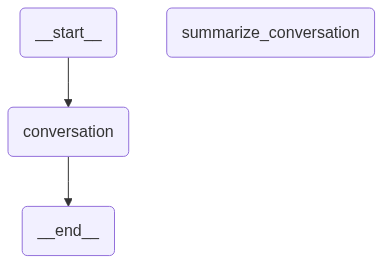

In [7]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation",summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)



# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## 线程（Threads）

The checkpointer saves the state at each step as a checkpoint.

检查点保存器在每一步将状态保存为一个检查点。

These saved checkpoints can be grouped into a `thread` of conversation.

这些保存的检查点可以被分组为一个 `thread` 对话。

Think about Slack as an analog: different channels carry different conversations.

将 Slack 作为类比来思考：不同的频道承载着不同的对话。

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

线程类似于 Slack 频道，捕获成组的状态集合（例如，对话）。

Below, we use `configurable` to set a thread ID.

下面，我们使用 `configurable` 来设置线程 ID。

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)



In [14]:
# Create a thread
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="你好我是张锡军")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="你是谁")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="我喜欢玩游戏")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

你好，张锡军！有什么我可以帮你的吗？😊
================================== Ai Message ==================================

我是通义千问，阿里巴巴集团旗下的超大规模语言模型。我可以帮助你回答问题、创作文字、进行逻辑推理、编程等任务。有什么我可以帮你的吗？😊
================================== Ai Message ==================================

那太棒了！游戏是一个很有趣的领域。你平时喜欢玩什么类型的游戏呢？是动作、冒险、角色扮演，还是策略类游戏？如果你有喜欢的游戏，可以告诉我，我们可以一起讨论或者分享一些游戏心得哦！😊


Now, we don't yet have a summary of the state because we still have < = 6 messages.

现在，我们还没有状态摘要，因为我们仍然有 < = 6 条消息。

This was set in `should_continue`. 

这被设置在 `should_continue`。

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

我们可以继续对话，因为我们有线索。



In [15]:
graph.get_state(config).values.get("summary","")

''

The `config` with thread ID allows us to proceed from the previously logged state!

带有 `config` 线程 ID 让我们能够从之前记录的状态继续！



In [16]:
input_message = HumanMessage(content="我喜欢玩lol，你知道这个游戏吗")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

当然知道！《英雄联盟》（League of Legends，简称 **LOL**）是一款非常受欢迎的多人在线战术竞技游戏（MOBA），由Riot Games开发。玩家在游戏中扮演“召唤师”，操控拥有独特技能的英雄，在一个名为召唤师峡谷的地图上与敌方队伍对抗，目标是通过团队合作和策略推倒敌方主基地。

你玩了多久啦？有特别喜欢的英雄或者位置（比如上单、打野、中单、AD、辅助）吗？如果你愿意分享，我可以陪你聊聊游戏心得，或者帮你分析对局哦！🎮😄


In [17]:
graph.get_state(config).values.get("summary","")

'以下是对以上对话的简要摘要：\n\n用户是张锡军，他表示自己喜欢玩游戏，特别是《英雄联盟》（LOL）。他确认了通义千问对这款游戏的了解。通义千问作为阿里巴巴集团旗下的超大规模语言模型，不仅能回答问题、创作文字，还能进行逻辑推理和编程等任务。对话中体现了用户对游戏的兴趣，以及希望在游戏方面获得更多互动与帮助的意愿。'

## 朗史密斯（LangSmith）

Let's review the trace!

让我们回顾一下trace！

